#  Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.

In [1]:
from fastai.vision.all import *

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)
path.ls()

(#3) [Path('/Users/sagartr/.fastai/data/mnist_sample/valid'),Path('/Users/sagartr/.fastai/data/mnist_sample/labels.csv'),Path('/Users/sagartr/.fastai/data/mnist_sample/train')]

In [4]:
Path.BASE_PATH = path

In [5]:
blocks = DataBlock(
    blocks = (ImageBlock(cls=PILImageBW),CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y = parent_label,
)
dls = blocks.dataloaders(path)

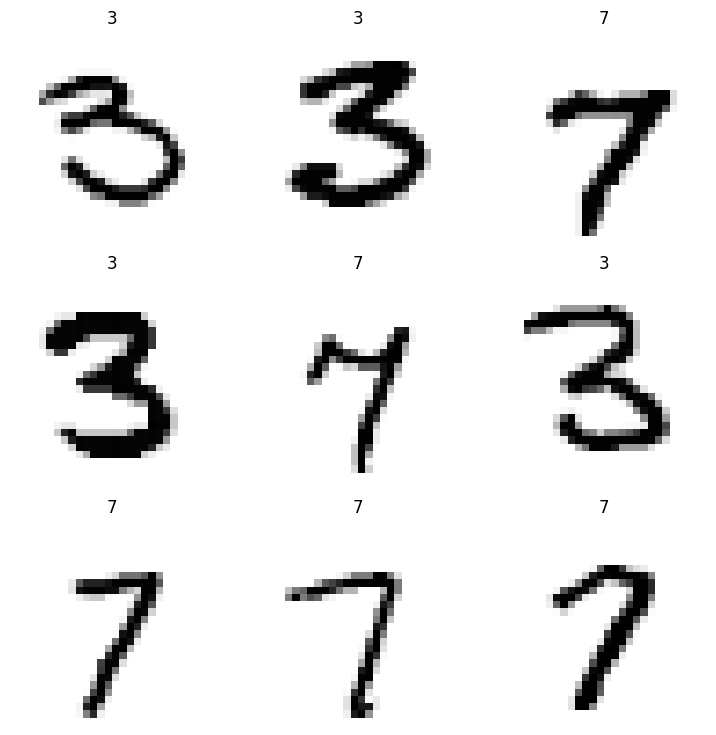

In [6]:
dls.show_batch()

In [7]:
x,y = dls.train.one_batch()
x.shape,y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [8]:
i=  0 
for  _,_ in enumerate(dls.valid):
    i=i+1

print(i+1)

33


In [9]:
i=  0 
for  k,z in dls.train:
    i=i+1
    #print(k)
    break
print(i+1)

2


In [10]:
type(k.as_subclass(Tensor))==type( Tensor(k))

True

In [11]:
linear_model = nn.Linear(28*28,1)
linear_model

Linear(in_features=784, out_features=1, bias=True)

In [30]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [23]:
def mnint_loss(target, pred):
    predictions = F.sigmoid(pred)
    return torch.where(target==1, 1-pred, pred).mean()

def acuracy(xb, yb):
    pred = xb.sigmoid()
    correct = (pred>0.5) == yb
    return correct.float().mean().item()
    

In [38]:
class learner():
    def __init__(self, dls=None, model, loss_func, metrics=None):
        self.dls = dls.to(device)
        self.model = model.to(device)
        self.loss_func = loss_func
        self.metrics = metrics
        
        self.params = [param for param in model.parameters()]
        self.lr  = 0.1
        
    def _calc_loss(self, target, pred):
        return self.loss_func(target, pred)

    
    def predict(self, x, infer=False):
        #if infer:
        #    with torch.no_grad():
        #        return self.model(x)
        return self.model(x)

    def train_loop(self, x, y):
        pred = self.predict(x)
        
        loss = self._calc_loss(y, pred)
        
        loss.backward()
        
        self.step()
        self.zero_grad()
        
        return loss.item()
        
    def step(self):
        for p in self.params: 
            p.data -= p.grad.data * self.lr
            
    def zero_grad(self):
        for p in self.params: 
            p.grad = None

    def calc_metrics(self, x, y):
        p =  self.metrics(self.predict(x, True), y)
        return p
        
    def fit(self, epoch, lr):
        self.lr =lr
        train_sz, valid_sz = len(dls.train), len(dls.valid)
        
        for i in range(epoch):
            epoch_loss, acc  = 0, 0
            valid_acc = 0
            for x, y in self.dls.train:
                x = Tensor(x).view(x.size(0),  -1)
                loss = self._train_loop(x, y)
                epoch_loss += loss
                acc += self.calc_metrics(x,y)
                
            for x, y in self.dls.valid:
                x = Tensor(x).view(x.size(0),  -1)
                valid_acc += self.calc_metrics(x,y)
                print(valid_acc)
                break
            print(f"{i} -->{epoch_loss/train_sz:.2f} ->> {acc/train_sz:.2f} -->> {valid_acc/valid_sz} ")
            

In [40]:
x, y  = dls.train.one_batch()
x = Tensor(x).view(x.size(0),  -1)
x.shape

torch.Size([64, 784])

In [46]:
l.calc_metrics(x,y) 

0.578125

In [45]:
[l.train_loop(x,y) for i  in range(10)]

[0.15549799799919128,
 0.07309812307357788,
 -0.025625646114349365,
 -0.14398333430290222,
 -0.2861146330833435,
 -0.45701199769973755,
 -0.6625698804855347,
 -0.9099818468093872,
 -1.2079850435256958,
 -1.5670920610427856]

In [39]:
l  = learner(dls, simple_net, mnint_loss, acuracy)

In [26]:
%%time
l.fit(5, 0.1)

1.0
0 -->0.51 ->> 0.51 -->> 0.03125 
1.0
1 -->0.48 ->> 0.51 -->> 0.03125 
1.0
2 -->0.40 ->> 0.51 -->> 0.03125 
1.0
3 -->-0.98 ->> 0.51 -->> 0.03125 
1.0
4 -->-4.90 ->> 0.51 -->> 0.03125 
CPU times: user 1min 59s, sys: 19.8 s, total: 2min 19s
Wall time: 3min 33s


In [26]:
import psutil

In [27]:
def display_gpu_memory_usage(used_memory, free_memory):
    """
    Display GPU memory usage in GB or MB format.

    Parameters:
    - used_memory (int): Used GPU memory in bytes.
    - free_memory (int): Free GPU memory in bytes.
    """
    # Convert bytes to gigabytes (GB) and megabytes (MB) for used and free memory
    used_gb = used_memory / (1024 ** 3)
    used_mb = used_memory / (1024 ** 2)
    free_gb = free_memory / (1024 ** 3)
    free_mb = free_memory / (1024 ** 2)

    # Determine the appropriate unit (GB or MB) based on the memory size
    if used_gb >= 1:
        used_str = f"{used_gb:.2f} GB"
    else:
        used_str = f"{used_mb:.2f} MB"

    if free_gb >= 1:
        free_str = f"{free_gb:.2f} GB"
    else:
        free_str = f"{free_mb:.2f} MB"

    print(f"GPU Memory Used: {used_str}, Free: {free_str}")

# Example usage:
# Get GPU memory usage using psutil
gpu_memory_stats = psutil.virtual_memory()
used_memory = gpu_memory_stats.used
free_memory = gpu_memory_stats.available
# Display GPU memory usage
display_gpu_memory_usage(used_memory, free_memory)


GPU Memory Used: 8.62 GB, Free: 6.37 GB


In [ ]:
URLs